# Regression, Classification, and Topic Insights

# Load Dataset

In [1]:

from pyspark.sql import SparkSession
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt



spark = SparkSession.builder \
    .appName("JobPostingsAnalysis") \
    .getOrCreate()

file_path = "lightcast_job_postings.csv"

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)
#df.show(5)



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/15 23:47:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Multiple Linear Regression

In [2]:
from pyspark.sql.functions import col, lower, when

# Create AI Role flag 
df = df.withColumn(
    "IS_AI_ROLE",
    when(
        # Specific AI/ML terms (these are safe)
        lower(col("TITLE_CLEAN")).rlike(r'\b(machine learning|deep learning|artificial intelligence|generative ai|neural network|computer vision|data scientist)\b') |
        lower(col("TITLE_RAW")).rlike(r'\b(machine learning|deep learning|artificial intelligence|generative ai|neural network|computer vision|data scientist)\b') |
        lower(col("LOT_V6_SPECIALIZED_OCCUPATION_NAME")).rlike(r'\b(machine learning|deep learning|artificial intelligence|generative ai|neural network|computer vision|data scientist)\b') |
        
        # AI as a standalone word (with spaces or punctuation around it)
        lower(col("TITLE_CLEAN")).rlike(r'(\s|^)ai(\s|$|/|-)') |
        lower(col("TITLE_RAW")).rlike(r'(\s|^)ai(\s|$|/|-)') |
        lower(col("LOT_V6_SPECIALIZED_OCCUPATION_NAME")).rlike(r'(\s|^)ai(\s|$|/|-)') |
        
        # ML Engineer/Scientist variants
        lower(col("TITLE_CLEAN")).rlike(r'\bml\s+(engineer|scientist|developer|analyst)\b') |
        lower(col("TITLE_RAW")).rlike(r'\bml\s+(engineer|scientist|developer|analyst)\b') |
        
        # NLP specifically
        lower(col("TITLE_CLEAN")).rlike(r'\bnlp\b') |
        lower(col("TITLE_RAW")).rlike(r'\bnlp\b'),
        1
    ).otherwise(0)
)


df.select(
    "TITLE_CLEAN",
    "TITLE_RAW",
    "LOT_V6_SPECIALIZED_OCCUPATION_NAME",
    "IS_AI_ROLE"
).orderBy(col("IS_AI_ROLE").desc()) \
 .show(5)




+--------------------+--------------------+----------------------------------+----------+
|         TITLE_CLEAN|           TITLE_RAW|LOT_V6_SPECIALIZED_OCCUPATION_NAME|IS_AI_ROLE|
+--------------------+--------------------+----------------------------------+----------+
|sr bi analyst dat...|Sr BI Analyst/Dat...|                      Data Analyst|         1|
|ai ml governance ...|AI/ML Governance ...|                      Data Analyst|         1|
|data engineering ...|Data Engineering ...|                      Data Analyst|         1|
|data engineering ...|Data Engineering ...|                      Data Analyst|         1|
|data engineering ...|Data Engineering ...|                      Data Analyst|         1|
+--------------------+--------------------+----------------------------------+----------+
only showing top 5 rows



In [3]:
# Missing Value Treatment
from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, expr, median
from pyspark.sql import functions as F

# Calculate overall median salary
overall_median_salarly = df.approxQuantile("SALARY", [0.5], 0.01)[0]

median_by_employment_type = df.groupBy("EMPLOYMENT_TYPE").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))
median_by_employment_type_name = df.groupBy("EMPLOYMENT_TYPE_NAME").agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join median values back to the original dataframe
df_salary_imputed = df.join(median_by_employment_type, on="EMPLOYMENT_TYPE", how = "left").join(median_by_employment_type_name, on="EMPLOYMENT_TYPE_NAME", how = "left")


# Replace missing SALARY values
df_salary_imputed=df_salary_imputed.withColumn("SALARY", when(col("SALARY").isNull(), 
                                when (col("median_salary_emp_type").isNotNull(), col("median_salary_emp_type"))
                                .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
                                .otherwise(overall_median_salarly)
).otherwise(col("SALARY"))) 

In [4]:
from pyspark.sql.functions import col, when, trim, regexp_replace, coalesce, lit
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

regression_df = df_salary_imputed.dropna(subset=["SALARY"])

# Impute numeric columns with median values
for c in ["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION"]:
    med = df_salary_imputed.approxQuantile(c, [0.5], 0.01)[0]
    if med is not None:
        regression_df = regression_df.na.fill({c: med})

# Cast duration to integer 
regression_df = regression_df.withColumn("DURATION", col("DURATION").cast(IntegerType()))

# Cast boolean columns to integers (0/1)
regression_df = regression_df.withColumn(
    "IS_INTERNSHIP", coalesce(col("IS_INTERNSHIP").cast(IntegerType()), lit(0))
)
regression_df = regression_df.withColumn(
    "COMPANY_IS_STAFFING", coalesce(col("COMPANY_IS_STAFFING").cast(IntegerType()), lit(0))
)


In [5]:
# Clean Remote Type Name
regression_df = regression_df.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

# Clean Employment Type Name
regression_df = regression_df.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

# Clean Education Levels
regression_df = regression_df.withColumn(
    "EDUCATION_LEVELS_NAME",
    trim(regexp_replace(col("EDUCATION_LEVELS_NAME"), r"[\[\]\n\"]", ""))
)
regression_df = regression_df.fillna({"EDUCATION_LEVELS_NAME": "No Education Listed"})

regression_df = regression_df.select(
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME",
    "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING", "IS_AI_ROLE"
)

regression_df.show(5, truncate=False)


+--------+--------------------+--------------------+---------------------+--------------------+----------------+--------+-------------+-------------------+----------+
|SALARY  |MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|EDUCATION_LEVELS_NAME|EMPLOYMENT_TYPE_NAME|REMOTE_TYPE_NAME|DURATION|IS_INTERNSHIP|COMPANY_IS_STAFFING|IS_AI_ROLE|
+--------+--------------------+--------------------+---------------------+--------------------+----------------+--------+-------------+-------------------+----------+
|116500.0|2                   |2                   |Bachelor's degree    |Fulltime            |Undefined       |6       |0            |0                  |0         |
|116500.0|3                   |3                   |No Education Listed  |Fulltime            |Remote          |18      |0            |1                  |0         |
|116500.0|5                   |3                   |Bachelor's degree    |Fulltime            |Undefined       |35      |0            |0                  |0         

In [6]:
ai_df = regression_df.filter(col("IS_AI_ROLE") == 1)
non_ai_df = regression_df.filter(col("IS_AI_ROLE") == 0)

if ai_df.count() > 0:
    ratio = non_ai_df.count() / ai_df.count()
    ai_df_balanced = ai_df.sample(withReplacement=True, fraction=ratio, seed=42)
    regression_df = non_ai_df.union(ai_df_balanced)


In [15]:
categorical_cols = ["EDUCATION_LEVELS_NAME", "EMPLOYMENT_TYPE_NAME",
                    "REMOTE_TYPE_NAME", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"]

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec", dropLast=True) for c in categorical_cols]
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION", "IS_AI_ROLE"] +
              [f"{c}_vec" for c in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)



In [16]:
# Split Data
regression_train, regression_test = regression_data.randomSplit([0.8, 0.2], seed=42)

print((regression_data.count(), len(regression_data.columns)))
print((regression_train.count(), len(regression_train.columns)))
print((regression_test.count(), len(regression_test.columns)))

(143304, 21)


(114523, 21)


(28781, 21)


In [17]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Train Multiple Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(regression_train)

summary = lr_model.summary

print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in summary.pValues])

predictions = lr_model.transform(regression_test)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")



25/10/16 00:07:01 WARN Instrumentation: [824826a6] regParam is zero, which might cause numerical instability and overfitting.



--- Regression Summary ---
Coefficient Standard Errors: ['32.3928', '95.9480', '7.7246', '175.9281', '7721025258.0866', '7721025258.0866', '7721025258.0866', '7721025258.0866', '7721025258.0867', '7721025258.0866', '7721025258.0867', '7721025258.0867', '7721025258.0867', '7721025258.0867', '7721025258.0868', '7721025258.0869', '7721025258.0869', '7721025258.0869', '7721025258.0869', '7721025258.0871', '7721025258.0873', '7721025258.0873', '7721025258.0877', '7721025258.0889', '7721025258.0897', '7721025258.0915', '7721025258.0921', '7721025258.0928', '7721025258.0965', '7721025258.1357', '7721025258.1357', '7721025258.1357', '774.5120', '934.6911', '508.8911', '541.3076', '670.3572', '696.2439', '262.1121', '7721025258.0864']
T-Values: ['131.1731', '-11.7128', '1.2925', '37.1572', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000

RMSE: 27364.34
R²: 0.199
MAE: 18576.90


In [18]:
predictions.select("SALARY", "prediction", "IS_AI_ROLE") \
    .groupBy("IS_AI_ROLE") \
    .agg(
        F.count("*").alias("job_count"),
        F.avg("SALARY").alias("avg_actual_salary"),
        F.avg("prediction").alias("avg_predicted_salary")
    ).orderBy("IS_AI_ROLE") \
    .show()

+----------+---------+------------------+--------------------+
|IS_AI_ROLE|job_count| avg_actual_salary|avg_predicted_salary|
+----------+---------+------------------+--------------------+
|         0|    14495|116886.82469817178|   116540.5085203994|
|         1|    14286|125283.93819123617|  124981.43042982712|
+----------+---------+------------------+--------------------+



## Multiple Linear Regression Interpretation
1. The Multiple Linear Regression (MLR) model achieved an RMSE of 27,364.34, an MAE of 18,576.90, and an R² of 0.199, indicating a moderate fit.
2. Salaries for AI-related roles are higher on average ($125,283 actual, $124,981 predicted) compared to non-AI roles ($116,887 actual, $116,541 predicted), confirming that AI specialization has a positive impact on compensation. 
3. The R² value of 0.199 indicates that the model explains about 20% of the variation in salaries, reflecting moderate predictive accuracy.
4. The t- and p-values indicate that numeric variables like experience and AI-role are statistically significant predictors, while inflated values for categorical variables result from multicollinearity due to one-hot encoding.


# Random Forest Regression

In [11]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=300,
    maxDepth=6,
    seed=42
)

# Train the model
rf_model = rf.fit(regression_train)

rf_predictions = rf_model.transform(regression_test)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")

rf_rmse = evaluator.evaluate(rf_predictions, {evaluator.metricName: "rmse"})
rf_r2   = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})
rf_mae  = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"})

print(f"RMSE: {rf_rmse:.2f}")
print(f"R²: {rf_r2:.3f}")
print(f"MAE: {rf_mae:.2f}")


25/10/15 23:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1102.7 KiB
25/10/15 23:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1880.3 KiB
25/10/15 23:58:34 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


RMSE: 24538.18
R²: 0.356
MAE: 15138.35


/tmp/ipykernel_1814/501214231.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top10_fi, palette="viridis")


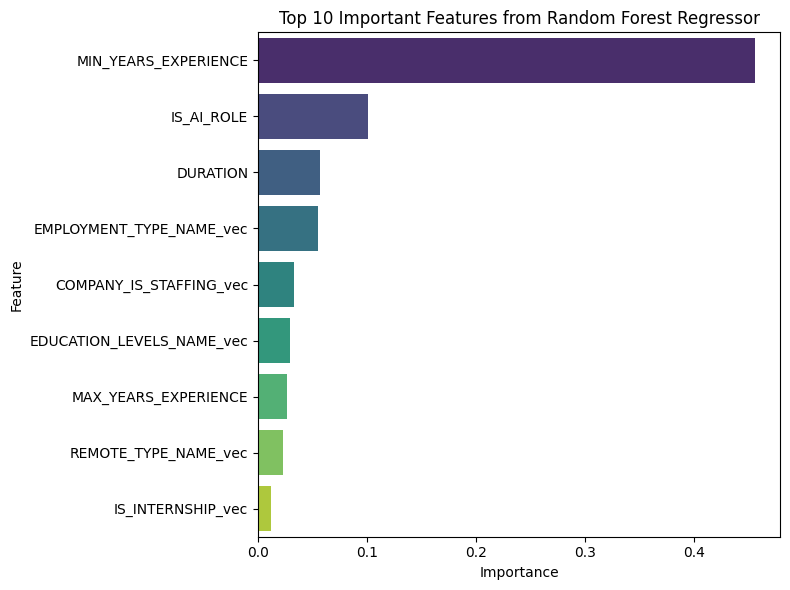

,Feature,Importance
0,MIN_YEARS_EXPERIENCE,0.455897
3,IS_AI_ROLE,0.101286
2,DURATION,0.057221
5,EMPLOYMENT_TYPE_NAME_vec,0.054882
8,COMPANY_IS_STAFFING_vec,0.032918
4,EDUCATION_LEVELS_NAME_vec,0.029114
1,MAX_YEARS_EXPERIENCE,0.026355
6,REMOTE_TYPE_NAME_vec,0.022659
7,IS_INTERNSHIP_vec,0.011788


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


importances = rf_model.featureImportances.toArray()

feature_names = assembler.getInputCols()

# Match lengths safely 
min_len = min(len(importances), len(feature_names))
feature_names = feature_names[:min_len]
importances = importances[:min_len]


fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top10_fi = fi_df.head(10)


plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=top10_fi, palette="viridis")
plt.title("Top 10 Important Features from Random Forest Regressor")
plt.tight_layout()

plt.show()
top10_fi

In [13]:
rf_predictions.select("SALARY", "prediction", "IS_AI_ROLE") \
    .groupBy("IS_AI_ROLE") \
    .agg(
        F.count("*").alias("job_count"),
        F.avg("SALARY").alias("avg_actual_salary"),
        F.avg("prediction").alias("avg_predicted_salary")
    ).orderBy("IS_AI_ROLE") \
    .show()


+----------+---------+------------------+--------------------+
|IS_AI_ROLE|job_count| avg_actual_salary|avg_predicted_salary|
+----------+---------+------------------+--------------------+
|         0|    14495|116886.82469817178|  117434.54269318607|
|         1|    14286|125283.93819123617|  124024.10018453641|
+----------+---------+------------------+--------------------+



## Random Forest Regression Interpretation
1. The Random Forest Regression model achieved an RMSE of 24,538.18, an MAE of 15,138.35, and an R² of 0.356, indicating a better fit.
2. Feature importance analysis demonstrates that minimum years of experience is the most influential predictor of salary, followed by AI role indicator, job duration, and employment type. These variables collectively contribute the most to explaining salary variation across job postings.
3. AI-related roles continue to show higher average salaries (**\$125,283** actual, **\$124,024** predicted) compared to non-AI roles (**\$116,887** actual, **\$117,435** predicted), suggesting that AI specialization has a consistent positive impact on compensation.
4. The R² value of 0.356 indicates that the model explains about 36% of the variation in salaries, which reflects moderate to good predictive accuracy.

# Compare 2 Models – Multiple Linear Regression and  Random Forest

In [14]:
import pandas as pd

# --- Multiple Linear Regression results ---
multiple_linear_results = {
    "Model": "Multiple Linear Regression",
    "RMSE": 27329.08,
    "R2": 0.201,
    "MAE": 18579.21,
    "AI_Job_Count": 14286,
    "NonAI_Job_Count": 14495,
    "AI_Actual_Salary": 125283.94,
    "AI_Pred_Salary": 125002.22,
    "NonAI_Actual_Salary": 116886.82,
    "NonAI_Pred_Salary": 116556.10
}

# --- Random Forest results ---
rf_results = {
    "Model": "Random Forest Regression",
    "RMSE": 24538.18,
    "R2": 0.356,
    "MAE": 15138.35,
    "AI_Job_Count": 14286,
    "NonAI_Job_Count": 14495,
    "AI_Actual_Salary": 125283.94,
    "AI_Pred_Salary": 124024.10,
    "NonAI_Actual_Salary": 116886.82,
    "NonAI_Pred_Salary": 117434.54
}


comparison_df = pd.DataFrame([multiple_linear_results, rf_results])
comparison_df


,Model,RMSE,R2,MAE,AI_Job_Count,NonAI_Job_Count,AI_Actual_Salary,AI_Pred_Salary,NonAI_Actual_Salary,NonAI_Pred_Salary
0,Multiple Linear Regression,27329.08,0.201,18579.21,14286,14495,125283.94,125002.22,116886.82,116556.10
1,Random Forest Regression,24538.18,0.356,15138.35,14286,14495,125283.94,124024.10,116886.82,117434.54


## Comparison Interpretation
1. The Random Forest Regression model outperforms the Multiple Linear Regression (MLR) model across all key performance metrics. It achieved a lower RMSE (24,538.18 vs. 27,329.08) and MAE (15,138.35 vs. 18,579.21), along with a higher R² value (0.356 vs. 0.201), indicating stronger predictive accuracy and a better ability to capture non-linear salary relationships.
2. Both models correctly reflect that AI-related roles have higher average salaries than non-AI roles.
3. Overall, the Random Forest model demonstrates improved performance by reducing prediction errors and explaining more variance in salaries, suggesting it is better suited for capturing  detailed patterns and non-linear relationships in the job postings dataset.
